In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import seaborn as sns
red, blue, green, purple, orange = sns.color_palette('Set1', 5)

from scipy.integrate import odeint

def Re(α, ρ, β, r):
    return α * β / (r * ρ) + (1-α) * β / r

sns.set_context('paper', font_scale=1.3)
sns.set_style('ticks')
mpl.rcParams['lines.linewidth'] = 2

from rakott.mpl import fig_panel_labels # pip install rakott

Equation system just for one city (e.g. Wuhan):
$$
\frac{dS}{dt} = - \beta \frac{S (I_1 + I_2)}{N}  \\
\frac{dE}{dt} = \beta \frac{S (I_1+I_2)}{N} - \delta E \\
\frac{dI_1}{dt} = (1-\alpha) \delta E - r I_1 - h I_1 \\
\frac{dI_2}{dt} = \alpha \delta E - \rho r I_2 - \frac{h}{\rho} I_2 \\
\frac{dH}{dt} = h (I_1 + I_2) - \gamma H \\
\frac{dR}{dt} = r (I_1 + \rho I_2) + \gamma H \\
N = S + E + I_1 + I_2 + H + R 
$$

Variables:
- $S$ susceptible
- $E$ exposed
- $I_1$ infected without priming
- $I_2$ infected with priming
- $H$ hospitalized
- $R$ recovered
- $N$ total population size (constant)

Parameters (all rates are in 1/day): 
- $\beta$ transmission rate
- $\delta$ incubation rate
- $\alpha$ fraction of population recieving priming
- $r$ clearance rate infected
- $\rho$ increase in clearance rate due to priming
- $h$ hospitalization rate of infected
- $\gamma$ clearance rate of hospitalized

In [37]:
def ode(y, t, β, δ, α, r, ρ, h, γ):
    S, E, I1, I2, H = y
    return [
        -β * S * (I1+I2) / N,        
         β * S * (I1+I2) / N - δ * E,  
         (1-α(t)) * δ * E  - r * I1 - h * I1,
            α(t)  * δ * E  - ρ * r * I2 - h/ρ * I2,
        h * (I1 + 1/ρ * I2) - γ * H
    ]

In [45]:
α_ = 1 # percent primed
ρ = 1.5 # effect of priming

# China - Li et al, Science 2020
# β = 1.12 * 0.14 + 1.12 * 0.55 * (1-0.14) # Jan 10-23
# β = 0.35 * 0.69 + 0.35 * 0.44 * (1-0.69)  # Jan 24 - Feb 8
# δ = 1/3.77 # Jan 10-23 (1/Z)
# δ = 1/3.5 # Jan 24 - Feb 8 (1/Z)
# r = 1/3.5 # (1/D)

# USA - Pei & Shaman, Zenodo 10.5281/zenodo.3722660
# Feb 21 - Mar 13
β = 0.95 * 0.08 + 0.95 * 0.64 * (1-0.08) # β * α + β * μ * α
δ = 1/3.59 #  (1/Z)
r = 1/3.56 # (1/D)

start_date = datetime(2020, 2, 21)

print('β={:.2}, 1/δ={:.2}, 1/r={:.2}'.format(β, 1/δ, 1/r))

# hospitalization parameters (using Verity et al 10.1101/2020.03.09.20033357)
h = 0.05 * r # 5% hospitalized, estimated from Verity et al and US Census age distribution
γ = 1/21 # three weeks in hospital, from Verity et al

E0 = 5000
N = 308000000
# N = 7000000
t = np.arange(0, 6*30.5, 1)
end_date = start_date + timedelta(days=t.max())

β=0.64, 1/δ=3.6, 1/r=3.6


In [39]:
def simulate(β, δ, α, r, ρ, h, γ):
    y0 = [N-E0, E0, 0, 0, 0]
    y = odeint(ode, y0, t, args=(β, δ, α, r, ρ, h, γ)).T
    S, E, I1, I2, H = y
    R = N - y.sum(axis=0)
    return S, E, I1, I2, H, R

In [40]:
def plot_simulation(S, E, I1, I2, H, R, ls='-', ax=None):
    if ax is None: fig, ax = plt.subplots()
    ax.plot(t, (I1+I1)/N, label='$I$', color=blue, ls=ls)
    ax.plot(t, H/N, label='$H$', color=red, ls=ls)
    ax.set_xlabel('Days from onset')
    ax.set_ylabel('Fraction of population')
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    ax.legend()
    return ax

In [55]:
def α0(t): 
    return 0
t0 = 76
print("Priming day:", start_date + timedelta(t0-1/δ))
def α_th(t):
    return 1 if t0 <= t < t0+7 else 0\

S_, E_, I1_, I2_, H_, R_ = simulate(β, δ, α0, r, ρ, h, γ)
Hmax_ = H_.max()

S, E, I1, I2, H, R = simulate(β, δ, α_th, r, ρ, h, γ)

print('Max hospitalization with vs without priming: {:.2%}'.format(1 - H.max() / Hmax_))

Priming day: 2020-05-03 09:50:24
Max hospitalization with vs without priming: 24.57%


In [56]:
def priming_effect(α, ρ): 
    S, E, I1, I2, H, R = simulate(β, δ, α, r, ρ, h, γ)
    return H.max()

αs = np.linspace(0, 1, 50)
ρs = np.linspace(1, 2, 50)
Hmax = np.array([[priming_effect(lambda t: α_ if t0 <= t < t0+7 else 0, ρ_) for α_ in αs] for ρ_ in ρs])

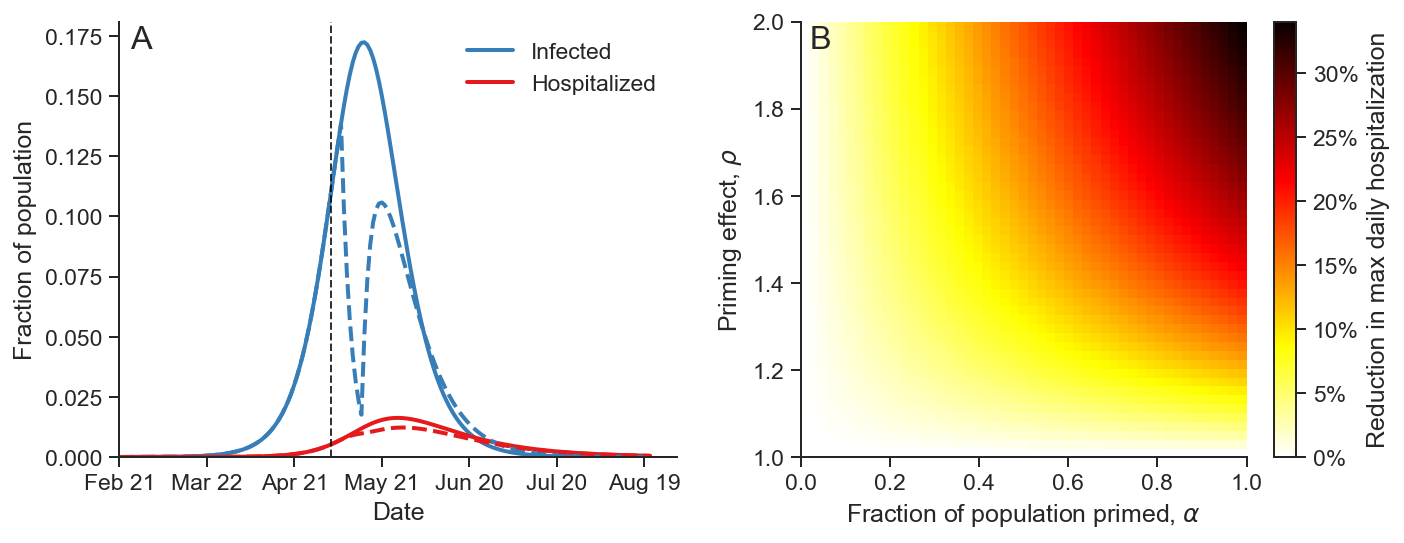

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
plot_simulation(S_, E_, I1_, I2_, H_, R_, ax=ax)
plot_simulation(S, E, I1, I2, H, R, ls='--', ax=ax)

ax.legend(['Infected', 'Hospitalized'], frameon=False)
ax.axvline(t0-1/δ, color='k', ls='--', alpha=0.8, lw=1)

ticks = np.arange(0, t.max(), 30)
ax.set_xticks(ticks)
ticklabels = [(start_date + timedelta(day)).strftime('%b %d') for day in ticks]
ax.set_xticklabels(ticklabels);
ax.set_xlabel('Date')

ax = axes[1]
im = ax.pcolormesh(αs, ρs, (1-Hmax/Hmax.max())*100, cmap='hot_r', rasterized=True)
ax.set(xlabel=r'Fraction of population primed, $\alpha$', ylabel=r'Priming effect, $\rho$')
plt.colorbar(im, ax=ax, label='Reduction in max daily hospitalization', format=mpl.ticker.PercentFormatter(decimals=0))

fig_panel_labels(axes, xcoord=0.02, ycoord=0.94)

fig.tight_layout()
fig.savefig('../figures/fig1-{}.pdf'.format(datetime.now().strftime('%y-%m-%d')), dpi=100)
fig.savefig('../figures/fig1-{}.png'.format(datetime.now().strftime('%y-%m-%d')))
sns.despine()

Figure 1. Effect of priming on epidemic dynamics. (A) Fraction of infected (blue) and hospitalized (red) individuals in the population over time without priming (solid lines) or with priming (dashed) if administered on May 5 (72 days from onset) to the entire population (α=1), assuming effect of priming lasts for one week. (B) Reduction in maximum daily hospitalization due to priming for various fractions of priming (α on x-axis) and effects of priming (ρ on y-axis). 
Dynamics are based on an SEIR model where infected can either be primed or unprimed. Model parameters based on estimated by Pei & Shaman (doi: 10.5281/zenodo.3722660, Table 3): transmission rate β=0.635; expected incubation time 1/δ=3.59 days; expected recovery time 1/r=3.56 days, or rρ if primed in the past week.
An additional model compartment for hospitalized individuals was added: infected individuals are hospitalized with rate h=0.014 per day (Verity et al. doi:10.1101/2020.03.09.20033357), or h/ρ if primed in the past week, for an expected duration of 1/γ=21 days (Verity et al. doi:10.1101/2020.03.09.20033357)